# Load the features and initialize the constants

In [5]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as kb
#from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split


from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, concatenate, LSTM
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# Visual Features

In [7]:
# ---------------------------------------
# Read feature names
# ---------------------------------------

f = open("../../Data/Visual/openface_feature_names.json", "r")
all_features = json.load(f)
f.close()

#Regex to link feature names to what they represent
feature_regex = {
    "action_units": ['AU'],
    "gaze": ['gaze'],
    "shape": ['p_'],
    "landmarks_2d": [' x_', ' y_'],
    "landmarks_3d": [' X_', ' Y_', ' Z_'],
    "eye_lmk_2d": ["lmk_x", "lmk_y"],
    "eye_lmk_3d": ["lmk_X", "lmk_Y", "lmk_Z"],
    "output": ["rating"]
}
features = defaultdict(list)
for feature, regexes in feature_regex.items():
    for col in all_features:
        for regex in regexes:
            if regex in col:
                features[feature].append(col)

#Features to use for training
training_features = ['gaze', 'landmarks_2d', 'eye_lmk_2d', 'shape']
training_features = [ftr_name for feature in training_features for ftr_name in features[feature]]

feature_indices = sorted([all_features.index(feature) for feature in training_features])

#Constants
FEATURE_INDICES = feature_indices
MAX_FRAMES_PER_VIDEO = 600 #Pad/Truncate data to maitain 800 frames
FEATURE_COUNT = len(FEATURE_INDICES)
print("Number of features used for training : ", FEATURE_COUNT)

Number of features used for training :  296


# Deep Learning

In [26]:
#Generator to load data in batches to avoid memory overflow

#Features and labels can be processed inside this generator
def gen(ftr_files):
    ftr_files = [file.decode() for file in ftr_files]
    
    for i, file in enumerate(ftr_files):
        #print(i, file)
        #Ignore hidden files such as '.dstore'
        #if '.npy' not in file:
        #    continue
        try: #If any issues with reading the current file or missing label, ignore the video
            ftrs = np.load(f'../../Data/Visual/visual_features_scaled/{file}.npy')
            label = np.load(f'../../Data/Labels/{file}.npy')
            
            ftrs = ftrs[:, FEATURE_INDICES]
            v_id = file.split('.')[0]
            
        except Exception as e:
            print(e)
            continue
        
        #Pad 0 valued frames(at the end) if frame count for the video lower than MAX_FRAMES_PER_VIDEO
        #Delete frames(from the front) if frame count grater than MAX_FRAMES_PER_VIDEO
        ftrs = tf.keras.preprocessing.sequence.pad_sequences([ftrs], maxlen=MAX_FRAMES_PER_VIDEO, 
                                                             dtype='float64', padding='post', 
                                                               truncating='pre', value=0.0)
        
        label = max(label, 0.001)
        #print(label)
        
        yield ftrs[0], label

In [27]:
#Generate an LSTM
def generate_model(input_size, max_length):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape = (input_size, max_length), name="input1"))
    
    rnn_layer = tf.keras.layers.LSTM(units = 50, activation = 'sigmoid', dropout = 0, recurrent_dropout = 0, implementation = 1, return_sequences = False)
    model.add(rnn_layer)
    
    dense_layer = tf.keras.layers.Dense(30)
    model.add(dense_layer)
    
    dense_layer = tf.keras.layers.Dense(1)
    model.add(dense_layer)
    
    model.compile(loss = 'mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2))
    #model.compile(loss=custom_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)) 
    model.build()
    model.summary()
    return model

def custom_loss(y_actual,y_pred):
    #custom_loss=100*(kb.abs((y_actual-kb.abs(y_pred)))/y_actual)
    #print(tf.executing_eagerly())
    #print(tf.math.equal(kb.abs(y_pred), y_pred))
    #x = tf.math.less(y_pred, kb.abs(y_pred))
    #if :
    custom_loss = tf.math.maximum(100.0, -1*(tf.math.sign(y_pred)*500))*(kb.abs((y_actual-kb.abs(y_pred)))/y_actual)
    return custom_loss#tf.math.max(custom_loss, custom_loss_2)

In [28]:
#Create the train and test datasets

#Create bins and return files from every bin. Files to be returned per bin are pre-defined
files_per_bin = 100
def get_train_test_files():
    ftr_files = [file for file in os.listdir('../../Data/Labels/') if '.npy' in file]
    np.random.shuffle(ftr_files)
    
    ratings = dict()        
    for file in ftr_files:
        video_id = file.split('.npy')[0]
        ratings[video_id] = [np.load(f'../../Data/Labels/{file}')]
    
    bins=10
    df_labels = pd.DataFrame.from_dict(ratings, orient='index', columns=['ratings'])
    #print(df_labels.columns, df_labels.index)
    #print(df_labels.groupby(pd.cut(df_labels['ratings'], bins=bins)).size())
    
    grps = df_labels.groupby(pd.cut(df_labels['ratings'], bins=bins))
    binned_files = [None for _ in range(bins)]
    for i, grp in enumerate(grps):
        video_id, _df = grp
        binned_files[i] = [file+".npy" for file in _df.index.values]
    
    #print(binned_files)
    #print(df_labels[df_labels['ratings']<0])
    
    #Keep x% of data as training
    train_size = 80 #In %age
    train, test = list(), list()
    for files in binned_files:
        files = files[:files_per_bin]
        file_count = len(files)
        split_index = (file_count*80)//100
        
        train += list(files[:split_index])
        test += list(files[split_index:])
    
    return train, test

#train, test = get_train_test_files()

#Video ids to be used
with open("../../Data/video_ids_balanced.json", "r") as f:
    ids_balanced = json.load(f)
ids_balanced = [vid[:-4] for vid in ids_balanced]

ids_count = len(ids_balanced)
split = (ids_count*80)//100
train, test = ids_balanced[:split], ids_balanced[split:]

# f = open("video_ids_unbalanced.json", "w")
# json.dump(train+test, f)
# f.close()
# print(len(train+test))

print(len(train), len(test))
#print(train, test)
#Training dataset
dataset_train = tf.data.Dataset.from_generator(
     gen, output_types=(tf.float64, tf.float64),
     output_shapes=(tf.TensorShape((None, None)), tf.TensorShape(())), args=(train,))

dataset_train_batched = dataset_train.batch(64, drop_remainder=True)
dataset_train_batched_prefetched = dataset_train_batched.prefetch(1)


#Test dataset
dataset_test = tf.data.Dataset.from_generator(
     gen, (tf.float64, tf.float64),
     output_shapes=(tf.TensorShape((None, None)), tf.TensorShape(())), args=(test,))
dataset_test_batched = dataset_test.batch(30, drop_remainder=True)
dataset_test_prefetched = dataset_test_batched.prefetch(1)

768 193


In [29]:
model = generate_model(MAX_FRAMES_PER_VIDEO, FEATURE_COUNT)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                69400     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 70,961
Trainable params: 70,961
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(dataset_train_batched, epochs=10, validation_data=dataset_test_batched)
#history = model.fit(dataset_train, epochs=10, validation_data=dataset_test)

Epoch 1/10
12/12 [==============================] - 12s 1s/step - loss: 0.5238 - val_loss: 0.4304
Epoch 2/10
12/12 [==============================] - 12s 997ms/step - loss: 0.4288 - val_loss: 0.6435
Epoch 3/10
12/12 [==============================] - 12s 981ms/step - loss: 0.6819 - val_loss: 0.2858
Epoch 4/10
12/12 [==============================] - 15s 1s/step - loss: 0.2435 - val_loss: 0.4463
Epoch 5/10
12/12 [==============================] - 11s 913ms/step - loss: 0.4948 - val_loss: 0.2131
Epoch 6/10
12/12 [==============================] - 12s 978ms/step - loss: 0.2895 - val_loss: 0.2176
Epoch 7/10
12/12 [==============================] - 10s 842ms/step - loss: 0.2860 - val_loss: 0.2192
Epoch 8/10
12/12 [==============================] - 11s 944ms/step - loss: 0.2897 - val_loss: 0.2149
Epoch 9/10
12/12 [==============================] - 12s 1s/step - loss: 0.2794 - val_loss: 0.2155
Epoch 10/10
12/12 [==============================] - 12s 959ms/step - loss: 0.2784 - val_loss: 0.215

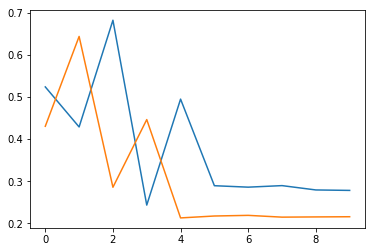

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

(180,) (180,)


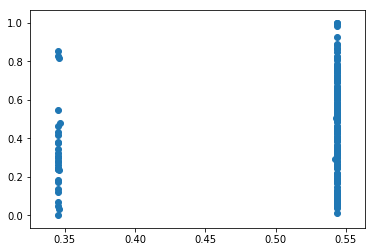

In [34]:
x_test = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[0]])
y_test = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[1]])
results = model.predict(x_test)
results = results.reshape(-1)
print(results.shape,y_test.shape)
plt.scatter(results, y_test)

In [35]:
print(f"Test MSE = {tf.keras.losses.MSE(y_test, results).numpy()}")

Test MSE = 0.06835222989320755


In [ ]:
tf.keras.utils.plot_model(model)